In [ ]:
!pip install tensorflow-text
!pip install tensorflow
!pip install transformers

In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

# data

In [ ]:
# data path
path = "/content/drive/MyDrive/Deep Learning  /ass2/data/Movie_Reviews.csv"

In [ ]:
data_not_proc = pd.read_csv(path)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#data not processed

In [ ]:
data_not_proc.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
Y = data_not_proc['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))
print(Y[:5])
data_not_proc['sentiment'] = Y

[1 1 1 0 1]


In [ ]:
data_not_proc.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
np.random.seed(112)
df_train_not_proc, df_val_not_proc, df_test_not_proc = np.split(data_not_proc.sample(frac=1, random_state=42),
                                     [int(.7*len(data_not_proc)), int(.8*len(data_not_proc))])
print(len(df_train_not_proc),len(df_val_not_proc), len(df_test_not_proc))

35000 5000 10000


#BERT MODEL history 1 not processed data

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(512, name="dense1")(l)
l = tf.keras.layers.Dense(256, name="dense2")(l)
l = tf.keras.layers.Dense(128, name="dense3")(l)
l = tf.keras.layers.Dense(64, name="dense4")(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model1 = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
from keras import backend as K

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity



In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      specificity,
      f1_m
]

opt = keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
history = model1.fit(df_train_not_proc['review'], df_train_not_proc['sentiment'], epochs=10, validation_data=(df_val_not_proc['review'], df_val_not_proc['sentiment']))

Epoch 1/10
1094/1094 [==============================] - 438s 389ms/step - loss: 0.6031 - accuracy: 0.6907 - precision: 0.6941 - recall: 0.6810 - specificity: 0.6106 - f1_m: 0.6640 - val_loss: 0.5034 - val_accuracy: 0.7620 - val_precision: 0.7423 - val_recall: 0.8088 - val_specificity: 0.6074 - val_f1_m: 0.7688
Epoch 2/10
1094/1094 [==============================] - 427s 390ms/step - loss: 0.5444 - accuracy: 0.7290 - precision: 0.7315 - recall: 0.7226 - specificity: 0.6416 - f1_m: 0.7144 - val_loss: 0.5138 - val_accuracy: 0.7540 - val_precision: 0.8469 - val_recall: 0.6251 - val_specificity: 0.7775 - val_f1_m: 0.7103
Epoch 3/10
1094/1094 [==============================] - 457s 417ms/step - loss: 0.5307 - accuracy: 0.7401 - precision: 0.7458 - recall: 0.7276 - specificity: 0.6505 - f1_m: 0.7265 - val_loss: 0.5398 - val_accuracy: 0.7272 - val_precision: 0.8730 - val_recall: 0.5371 - val_specificity: 0.7892 - val_f1_m: 0.6550
Epoch 4/10
1094/1094 [==============================] - 456s 417

In [ ]:
model1.save('/content/drive/MyDrive/Deep Learning  /ass2/Models/m_history_not_processed')

In [ ]:
import pickle

In [ ]:
pickle_out = open("/content/drive/MyDrive/Deep Learning  /ass2/History/history_not_processed.pickle","wb")
pickle.dump(history,pickle_out)
pickle_out.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
......keras_layer
.........vars
......keras_layer_1
.........vars
............0
............1
............10
............100
............101
............102
............103
............104
............105
............106
............107
............108
............109
............11
............110
............111
............112
............113
............114
............115
............116
............117
............118
............119
............12
............120
............121
............122
............123
............124
............125
............126
............127

#installations

In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 11.2 MB/s 
     |████████████████████████████████| 588.3 MB 17 kB/s 
     |████████████████████████████████| 6.0 MB 58.3 MB/s 
     |████████████████████████████████| 439 kB 72.7 MB/s 
     |████████████████████████████████| 1.7 MB 67.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.7 MB/s 
     |████████████████████████████████| 7.6 MB 53.9 MB/s 
     |████████████████████████████████| 182 kB 71.0 MB/s 


#Properties

In [ ]:
print("The Macro-F1 score: ", history.history['accuracy'])
print("The Macro-F1 score: ", history.history['precision'])
print("The Macro-F1 score: ", history.history['recall'])
print("The Macro-F1 score: ", history.history['specificity'])
print("The Macro-F1 score: ", history.history['f1_m'])

The Macro-F1 score:  [0.6907428503036499, 0.7289714217185974, 0.7400571703910828, 0.7396571636199951, 0.7416285872459412, 0.7454285621643066, 0.7494857311248779, 0.7444285750389099, 0.746657133102417, 0.7478857040405273]
The Macro-F1 score:  [0.6941059827804565, 0.7315420508384705, 0.7458223104476929, 0.7455847263336182, 0.7474492788314819, 0.7496069669723511, 0.755078136920929, 0.7489793300628662, 0.7509904503822327, 0.7520815134048462]
The Macro-F1 score:  [0.6810044050216675, 0.7225876450538635, 0.7275639176368713, 0.7268203496932983, 0.7291082739830017, 0.7363152503967285, 0.7378024458885193, 0.7345421314239502, 0.7372876405715942, 0.7388319969177246]
The Macro-F1 score:  [0.6106477975845337, 0.641596794128418, 0.6505126357078552, 0.6520824432373047, 0.6524360179901123, 0.6532698273658752, 0.6578161716461182, 0.6576863527297974, 0.6564511060714722, 0.6600782871246338]
The Macro-F1 score:  [0.6639633774757385, 0.7143908739089966, 0.7264534831047058, 0.726128101348877, 0.727758705615

In [ ]:
import matplotlib.pyplot as plt

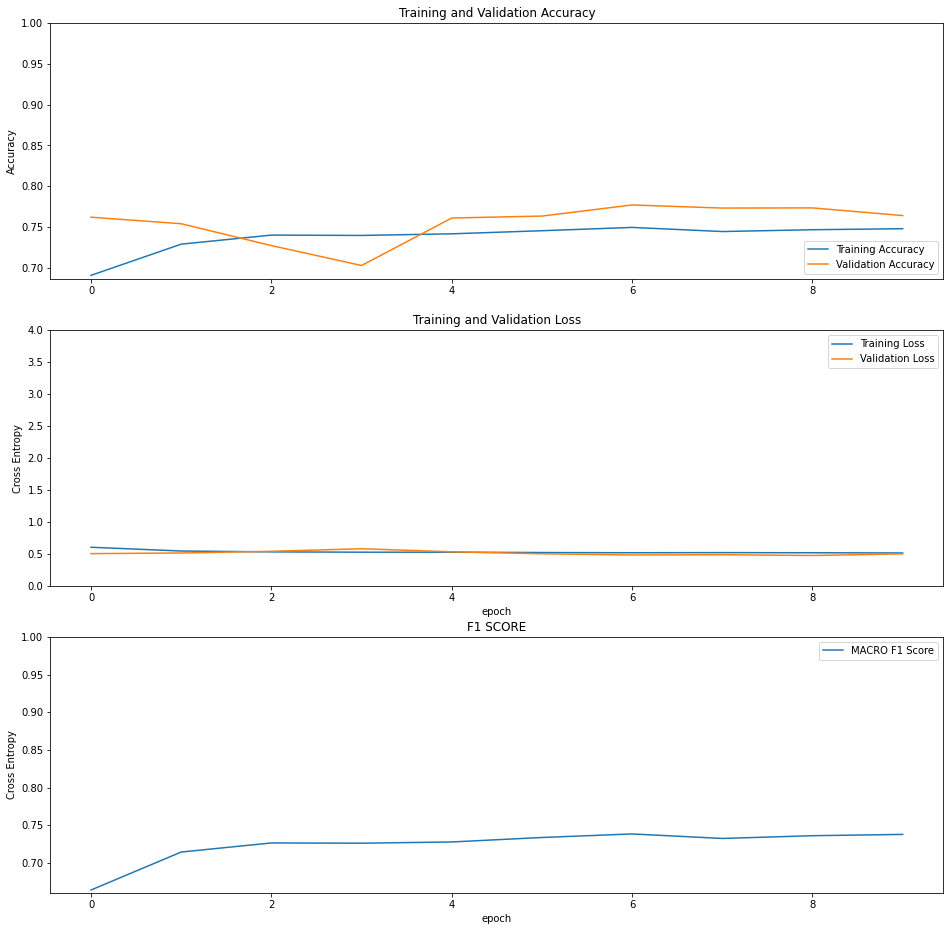

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
f1_m = history.history['f1_m']

plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(f1_m, label='MACRO F1 Score')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('F1 SCORE')
plt.xlabel('epoch')
plt.show()

# Evaluation & Conf matrix

In [ ]:
# Evaluate the model on the test data using `evaluate`
test_set = (df_test_not_proc['review'],df_test_not_proc['sentiment'])
print("Evaluate on test data")
results = model1.evaluate(df_test_not_proc['review'],df_test_not_proc['sentiment'])
print("test loss, test accuracy, test precision, test recall, test specificity, test f1 score:", results)

Evaluate on test data
313/313 [==============================] - 103s 328ms/step - loss: 0.4958 - accuracy: 0.7682 - precision: 0.7243 - recall: 0.8655 - specificity: 0.5774 - f1_m: 0.7836
test loss, test accuracy, test precision, test recall, test specificity, test f1 score: [0.4957832992076874, 0.7681999802589417, 0.7242881059646606, 0.8654924035072327, 0.5774088501930237, 0.7836019396781921]


In [ ]:
predicts = model1.predict(df_test_not_proc['review'])

313/313 [==============================] - 102s 324ms/step


In [ ]:
predicts

array([[0.3583541 ],
       [0.8941317 ],
       [0.62110287],
       ...,
       [0.3761511 ],
       [0.8403608 ],
       [0.94630206]], dtype=float32)

In [ ]:
y_predicted = np.where(predicts > 0.5, 1, 0)
print(y_predicted)

[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
def plotConfMat(predicted_label):
  cm = confusion_matrix(test_set[1], predicted_label)
  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 12},
       cbar = False, fmt='d', cmap='Purples');
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  plt.show()

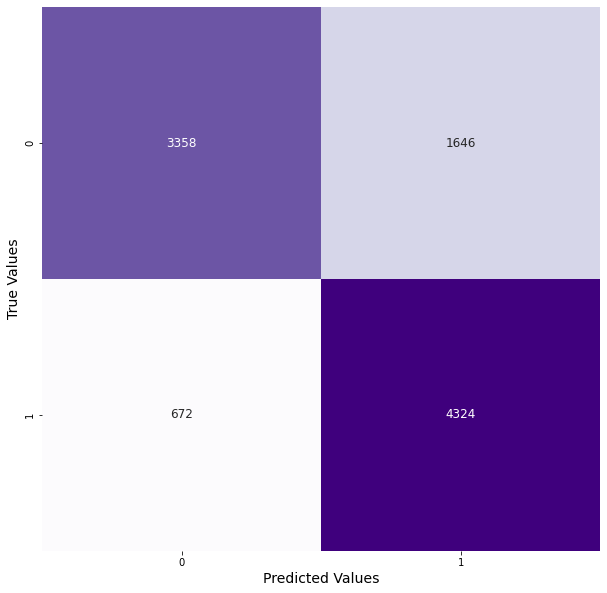

In [ ]:
plotConfMat(y_predicted)

In [ ]:
print(classification_report(test_set[1], y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      5004
           1       0.72      0.87      0.79      4996

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



#example predection

0 --> 1 the range negative --> positive

In [ ]:
rev = ['the movie was so good tonight','i didnt like the movie that much it was boring','the movie was one of the best movies i\'ve ever seen']
model1.predict(rev)

1/1 [==============================] - 1s 738ms/step


array([[0.85269856],
       [0.20021856],
       [0.68336684]], dtype=float32)